Title:


Introduction:
Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
Clearly state the question you will try to answer with your project
Identify and describe the dataset that will be used to answer the question

Preliminary exploratory data analysis:
Demonstrate that the dataset can be read from the web into R 
Clean and wrangle your data into a tidy format
Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis. 

Introduction:

IMDB is an online database of information related to films, television series, podcasts, and other forms of entertainment content. For our project we will be working specifically with movie (film) data from IMDB. This database presents data regarding several aspects of the content - including cast, production crew, plot summary, and scores. IMDB presents two kinds of scores; IMDB scores which are user-generated, meaning they are an average of reviews submitted on the IMDB website by non-critic viewers, and Meta Scores which are critic-generated, meaning they are an average of reviews from critics, professionals who analyze films. 

For our project we will try to answer the following question:
"How accurate are the Meta Scores of films in representing the general interest of the viewers?"

The dataset presented is from Kaggle, and includes data from the top 1000 movies based on the IMDB score from the IMBD online database. The dataset includes data for movie name (Series_Title), year of release (Released_year), certificate earner by the movie e.g. R, A, UA, U (Certificate), total runtime (Runtime), genre (Genre), the IMDB score of the movie (IMDB_Rating), plot summary (Overview), the Meta score of the movie (Meta_score), the director (Director), stars of the movie (Star1, Star2, Star3, Star4), number of reviews on IMDB (No_of_votes), and the amount of money earned by the movie (Gross). For this project will analyze the relationship between audience perception of a movie (IMDB scores) and the Meta scores of the movies.


Dataset Origin: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

In [1]:
### Initialize. 
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




In [2]:
### Reading from Github
url <- "https://github.com/anh-dong/dsci-100-2023w1-group-33/blob/main/data/imdb_top_1000.csv?raw=true"
movies_raw <- read_csv(url) |>
    select(-Poster_Link, -Overview) |>
    filter(Released_Year > 1970)
# movies_raw
# selectors <- paste()
movies_raw

Rows: 499 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): Poster_Link, Series_Title, Certificate, Runtime, Genre, Overview, ...
dbl  (4): Released_Year, IMDB_Rating, Meta_score, No_of_Votes
num  (1): Gross

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
The Shawshank Redemption,1994,A,142 min,Drama,9.3,80,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469
The Godfather,1972,A,175 min,"Crime, Drama",9.2,100,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,84,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Letters from Iwo Jima,2006,UA,141 min,"Action, Adventure, Drama",7.9,89,Clint Eastwood,Ken Watanabe,Kazunari Ninomiya,Tsuyoshi Ihara,Ryô Kase,154011,13756082
The Fall,2006,R,117 min,"Adventure, Drama, Fantasy",7.9,64,Tarsem Singh,Lee Pace,Catinca Untaru,Justine Waddell,Kim Uylenbroek,107290,2280348
Life of Pi,2012,U,127 min,"Adventure, Drama, Fantasy",7.9,79,Ang Lee,Suraj Sharma,Irrfan Khan,Adil Hussain,Tabu,580708,124987023


In [3]:
### Table Summary

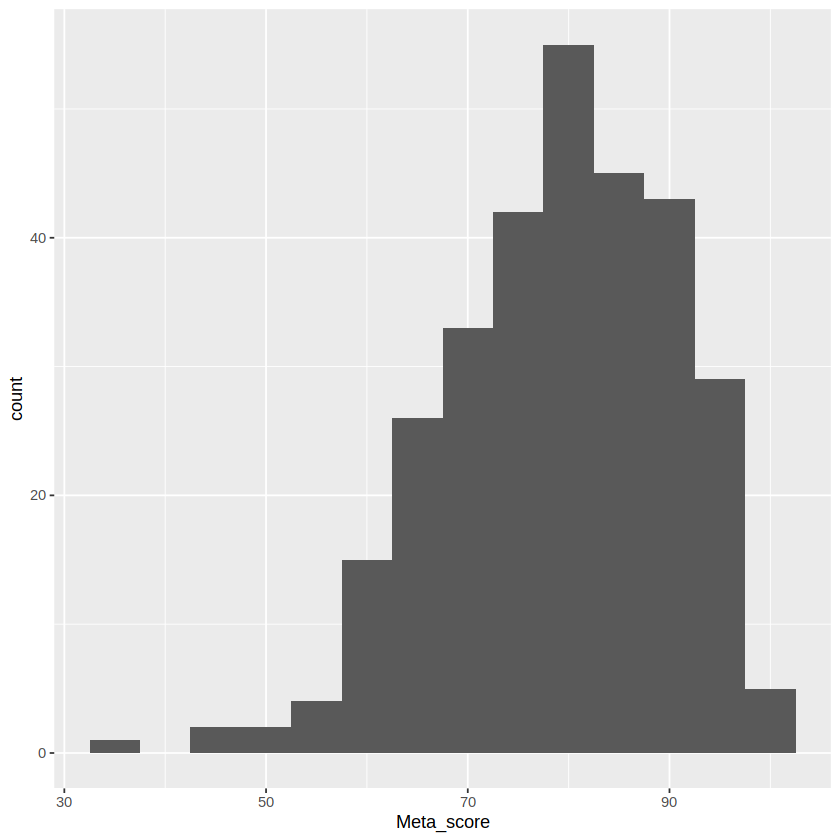

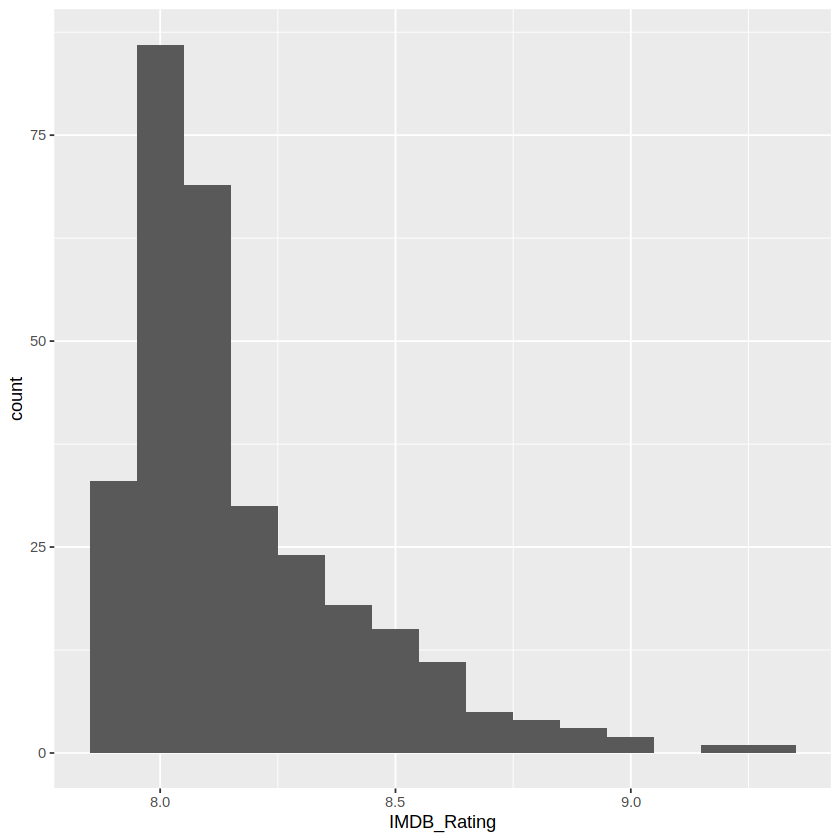

In [10]:
### Summary Visual
movies <- movies_raw |>
    select(Meta_score, IMDB_Rating) |>
    na.omit()

Meta_score_hist <- movies |>
    ggplot(aes(Meta_score)) +
        geom_histogram(binwidth = 5) +
Meta_score_hist

IMDB_Review_hist <- movies |>
    ggplot(aes(IMDB_Rating)) +
        geom_histogram(binwidth = 0.1)
IMDB_Review_hist

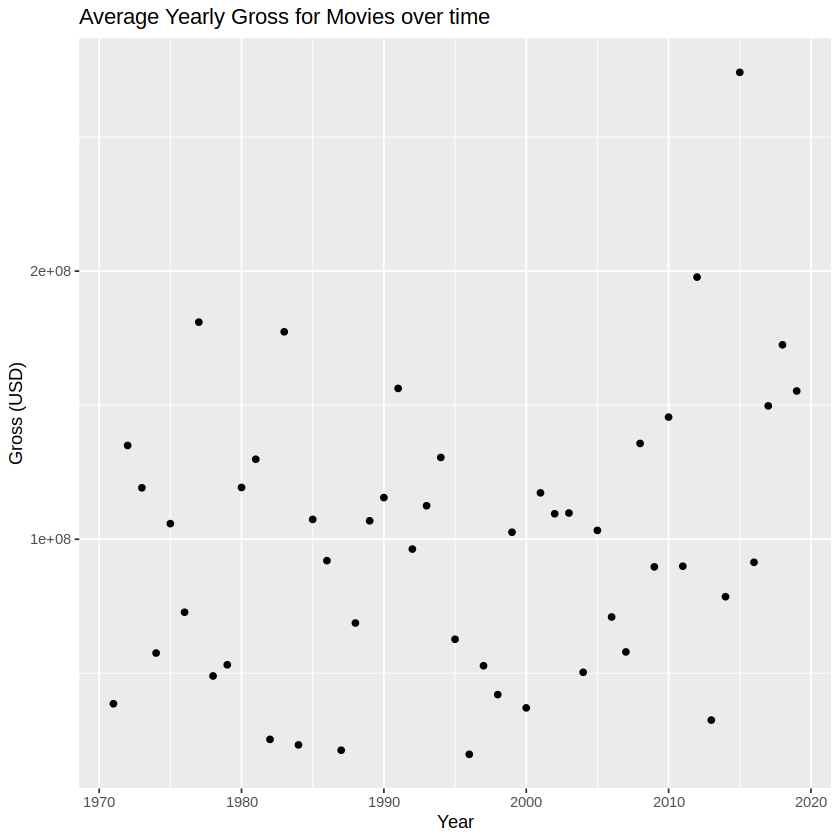

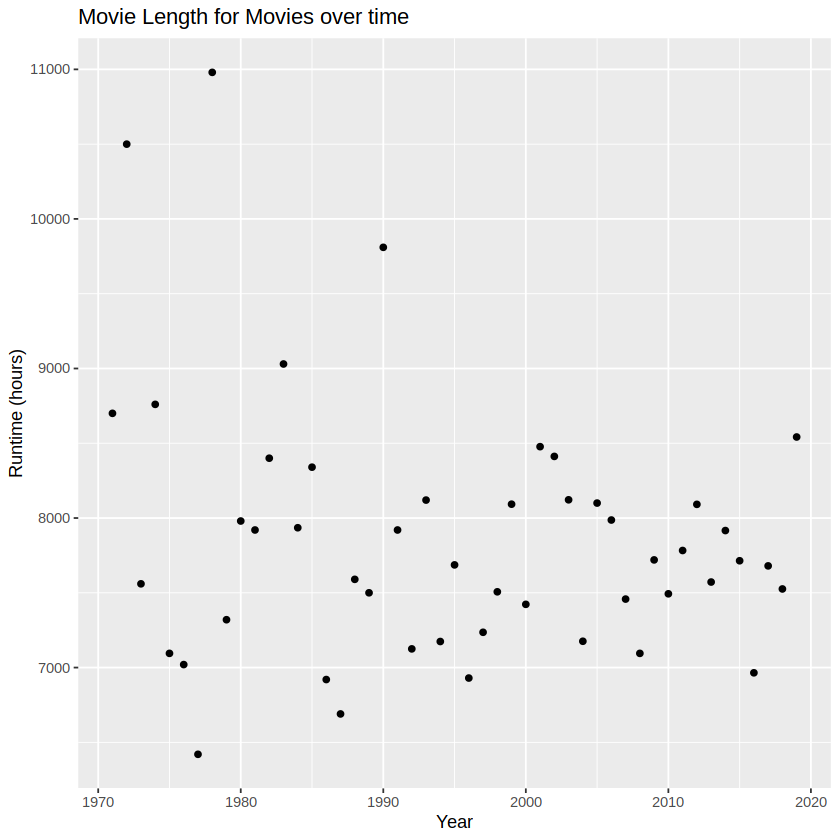

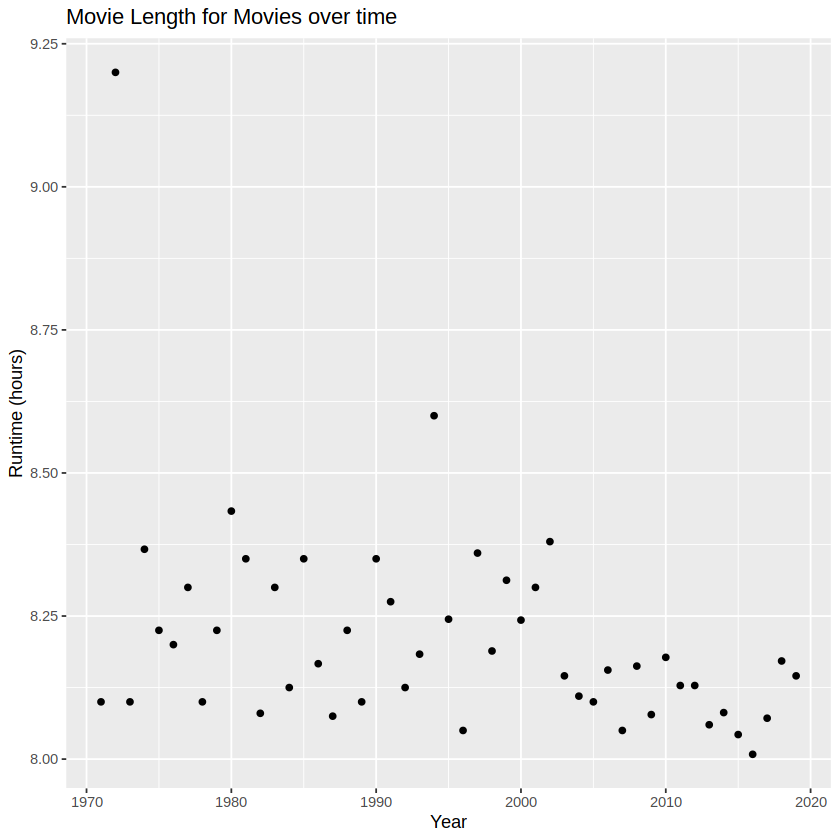

In [5]:
movies <- movies_raw |>
    select(Released_Year, Meta_score, Gross, Runtime, IMDB_Rating) |>
    na.omit() |>
    mutate(Runtime = strtoi(Runtime %>% str_replace(" min", ""))) |>
    group_by(Released_Year) |>
    summarize(ave_Gross = mean(Gross), ave_runtime = mean(Runtime)*60, ave_score = mean(Meta_score), ave_IMDB_Rating = mean(IMDB_Rating)) |>
    arrange(Released_Year)
# movies
movies_plot <- movies |>
    ggplot(aes(Released_Year, ave_Gross)) +
        geom_point() +
        xlab("Year") +
        ylab("Gross (USD)") +
        ggtitle("Average Yearly Gross for Movies over time")
movies_plot
movies_plot_2 <- movies |>
    ggplot(aes(Released_Year, ave_runtime)) +
        geom_point() +
        xlab("Year") +
        ylab("Runtime (hours)") +
        ggtitle("Movie Length for Movies over time")
movies_plot_2
movies_plot_3 <- movies |>
    ggplot(aes(Released_Year, ave_IMDB_Rating)) +
        geom_point() +
        xlab("Year") +
        ylab("Runtime (hours)") +
        ggtitle("Movie Length for Movies over time")
movies_plot_3


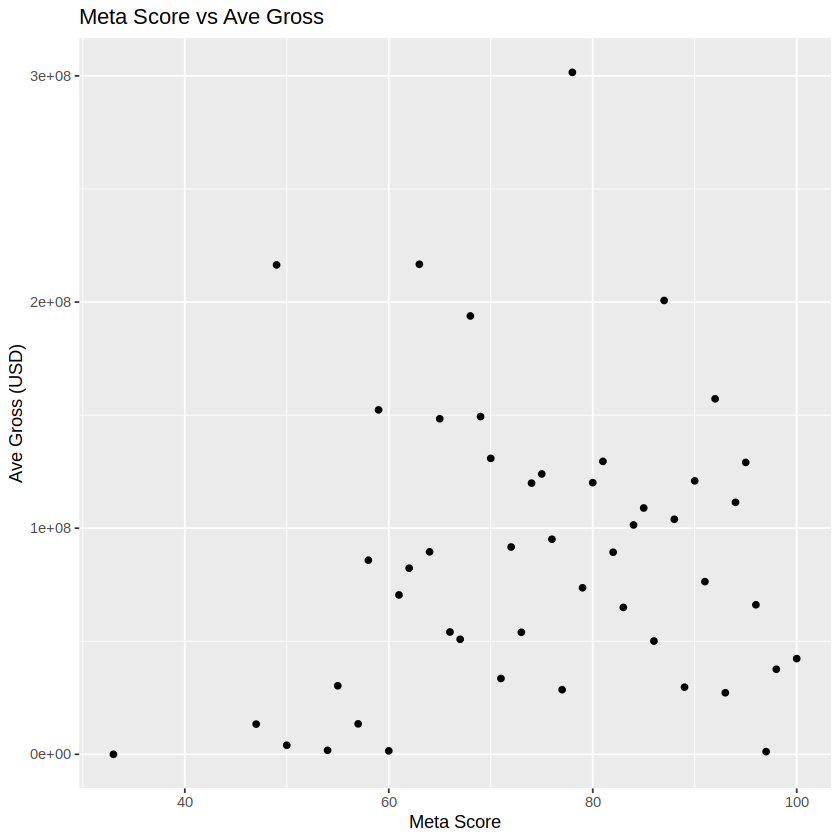

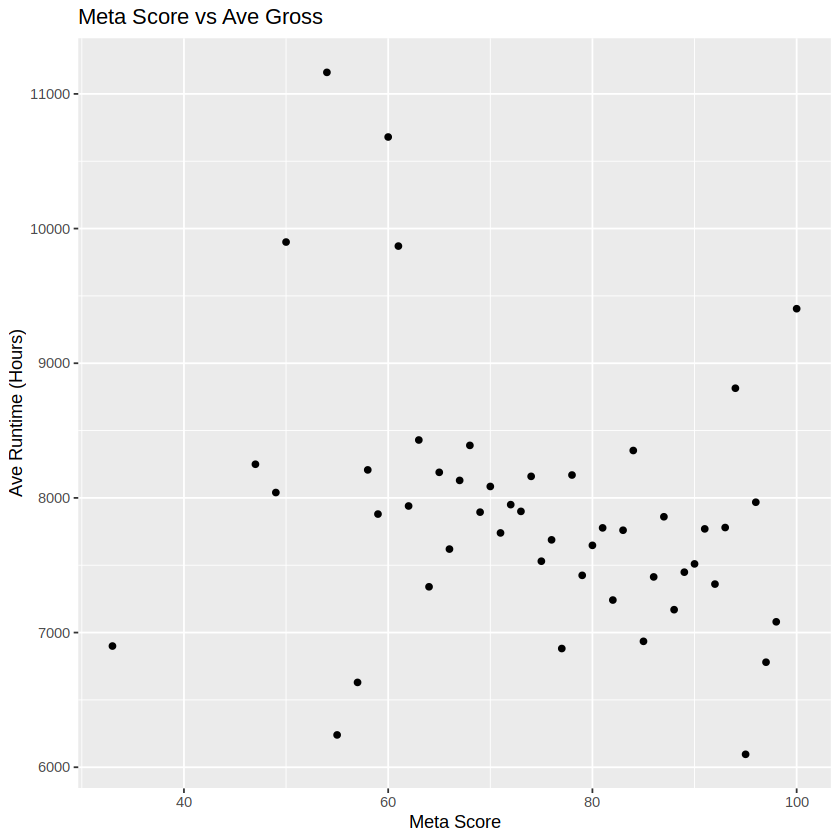

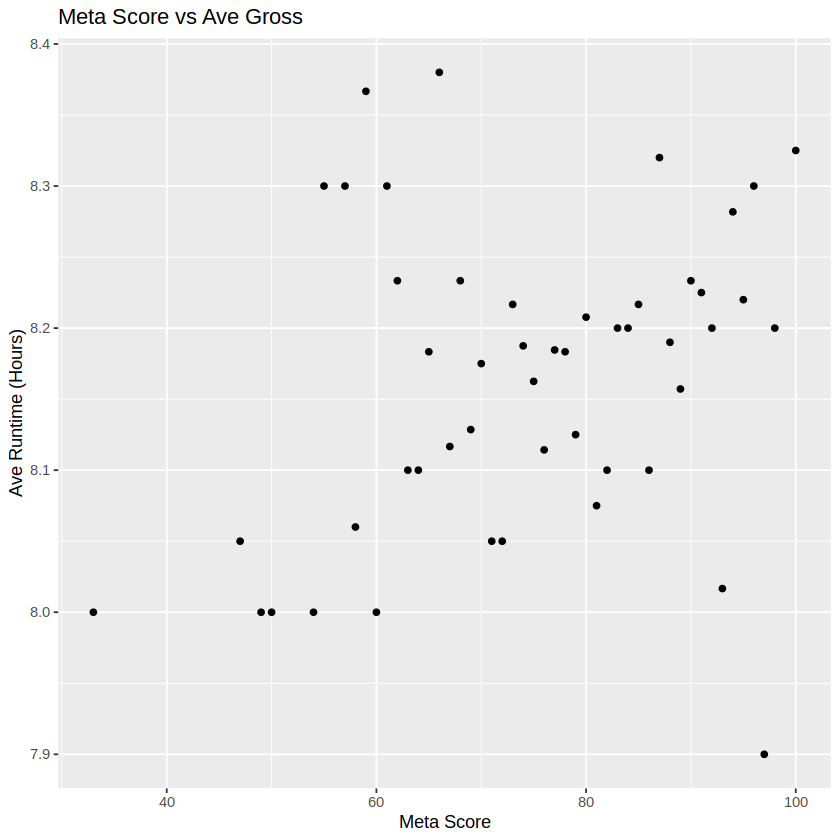

In [6]:
movies2 <- movies_raw |>
    select(Meta_score, Gross, Runtime, IMDB_Rating) |>
    na.omit() |>
    mutate(Runtime = strtoi(Runtime %>% str_replace(" min", ""))) |>
    group_by(Meta_score) |>
    summarize(ave_Gross = mean(Gross), ave_runtime = mean(Runtime)*60, ave_IMDB_Rating = mean(IMDB_Rating))
movies_plot_3 <- movies2 |>
    ggplot(aes(Meta_score, ave_Gross)) +
        geom_point() +
        xlab("Meta Score") +
        ylab("Ave Gross (USD)") +
        ggtitle("Meta Score vs Ave Gross")
movies_plot_3
movies_plot_3 <- movies2 |>
    ggplot(aes(Meta_score, ave_runtime)) +
        geom_point() +
        xlab("Meta Score") +
        ylab("Ave Runtime (Hours)") +
        ggtitle("Meta Score vs Ave Gross")
movies_plot_3
movies_plot_4 <- movies2 |>
    ggplot(aes(Meta_score, ave_IMDB_Rating)) +
        geom_point() +
        xlab("Meta Score") +
        ylab("Ave Runtime (Hours)") +
        ggtitle("Meta Score vs Ave Gross")
movies_plot_4

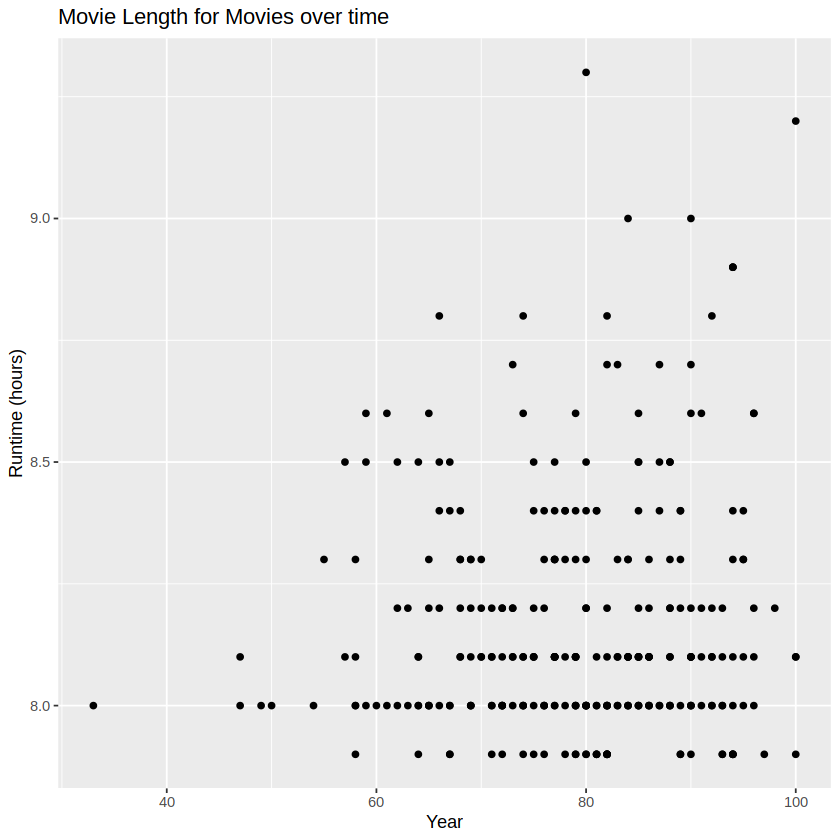

In [7]:
movies3 <- movies_raw |>
    select(Meta_score, Gross, Runtime, IMDB_Rating) |>
    na.omit() |>
    mutate(Runtime = strtoi(Runtime %>% str_replace(" min", "")))
movies_plot_3 <- movies3 |>
    ggplot(aes(Meta_score, IMDB_Rating)) +
        geom_point() +
        xlab("Year") +
        ylab("Runtime (hours)") +
        ggtitle("Movie Length for Movies over time")
movies_plot_3

Methods:


Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
Describe at least one way that you will visualize the results

Expected outcomes and significance:


What do you expect to find?
What impact could such findings have?
What future questions could this lead to?

Expected Outcomes and Significance:

Our prediction is that that the Meta Scores will be somewhat proportional to each other, but will vary to some extent. We expect this variation because the individuals who provided the reviews for which the IMDB scores are based off of are most likely 